# I<sup>2</sup>CCF

### Introduction
PyI<sup>2</sup>CCF is a python improved ICCF code to measure the time lag between AGN continuum and emission-line light curves in reverberation mapping projects. This code is able to measure the time lag, lag uncertainties with flux randomization method, and lag significance based on simulated light curves. The difference between our code and PyCCF [(Sun et al. 2018)](https://ui.adsabs.harvard.edu/abs/2018ascl.soft05032S/abstract) is that 1) we added a portion to evaluate the lag significance and 2) we are able to interpolate light curve with more complicated CARMA model (Kelly et al. [2009](https://ui.adsabs.harvard.edu/abs/2009ApJ...698..895K/abstract), [2014](https://ui.adsabs.harvard.edu/abs/2014ApJ...788...33K/abstract)). The main flows of this code are:

1) Measure the time lag between continuum and emission-line light curve 

2) Run Monte Carlo with flux randomization to evaluate the lag uncertainties of lag peak/centroid

3) Measure the time lag between real continuum (emission-line) and simulated emission-line (continuum) light curves to evaluate the significance of the real-data-based time lag.

Things need to know:

1) If interpolate light curve with linear mode, significance partion (function CalSig) will will default CARMA model (p=1,q=0) or best CARMA model (if auto_pq=True) to produce simulated light curves.

2) For significance evaluation, we simply assume that both continuum and emission-line follow the same CARMA model.

3) It takes ~ tens of minutes to get the best p and q if auto_pq = True. 

4) It is very slow to do the CCF with a high-order CARMA model. 


### Installation and Requirments
To install this code, just copy the whole package (with git -clone) to your working directory. This code is only working with Python 2.7 due to the Python2-based CARMA pack. Some packages are required:

1) tested on Numpy (1.16.6), Scipy (1.2.3), Matplotlib (2.2.5)  

2) [carma_pack](https://github.com/brandonckelly/carma_pack), which will need acor, [Boost C++ libraries](https://www.boost.org/) (version 1.59) and [Armadillo C++ linear algebra library] (http://arma.sourceforge.net/)

Anaconda is recommended, which has included Numpy, Scipy, and Matplotlib. If you have to install anaconda 2 (python 2) or 3 (python3), you just need to set up the [coexiting environmnent](https://docs.anaconda.com/anaconda/user-guide/tasks/switch-environment/). Armadillo is easy to install (e.g., brew install armadillo). Make sure the Boost has the right version (do not use higher version than 1.64), and the Boost dylib can be found by Python (see details in carma installation)


### Future works
1) Transfer carma into python3 or totally use other methods (e.g., Gaussian process) to fit the light curves.

2) Speed up the code.

3) Support multi-band lag measurements, e.g., one continuum and several emission-line light curves.

4) Update a better weight method.

### Example

#### 1) Run an example with linear interpolation.
We start to test our code with a quasar, SDSS-RM 32 ([Grier et al. 2019](https://ui.adsabs.harvard.edu/abs/2019ApJ...887...38G/abstract)), which is one of the best object in RM project. We first measure the time lag with linear interpolation. For significance evaluation, we simplely assume the DRW model is the best model for this object. A better way is to turn on the auto_pq to find the best CARMA model for this object, which would be very time-comsuming.     

Fitting finished in : 71.61s


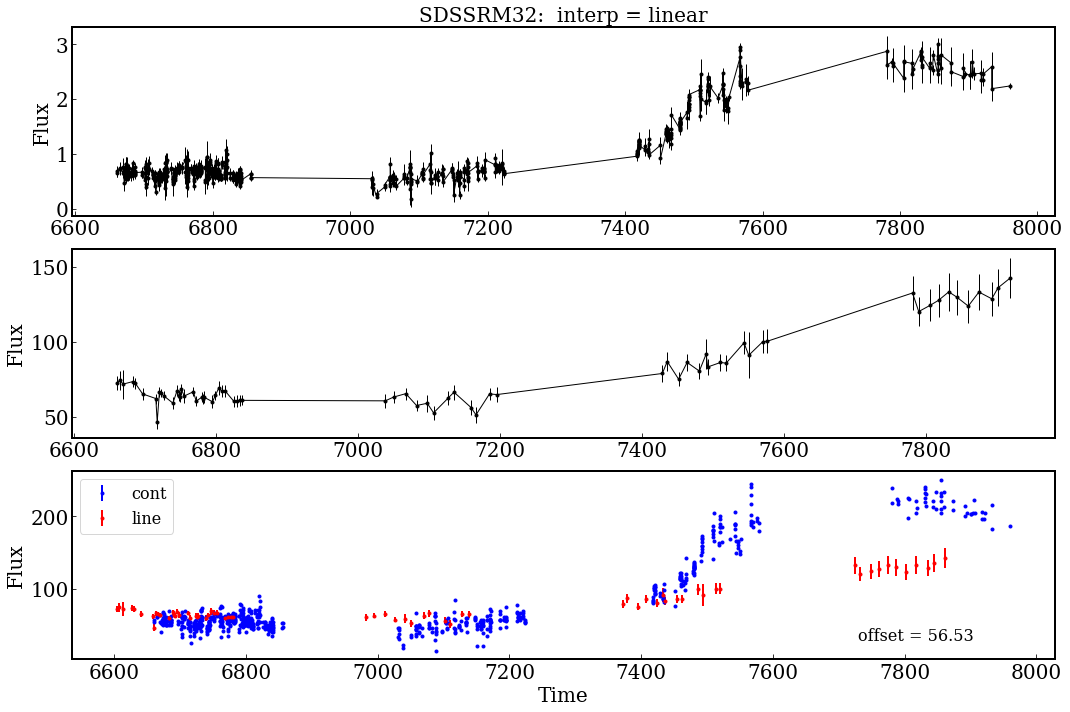

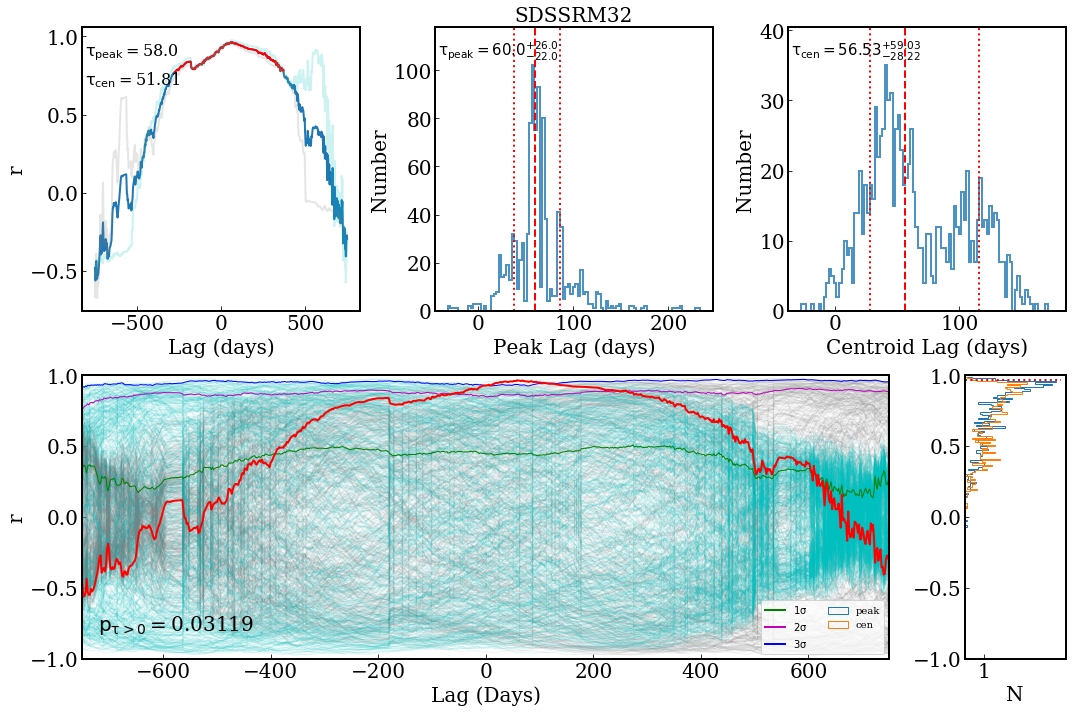

In [51]:
%matplotlib inline
import numpy as np
import carmcmc as cm
import glob,os,sys,timeit
from ccf import CCF
from matplotlib import pyplot as plt
#plt.style.use('my')

#set figure styles
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.linewidth']=2
plt.rcParams['xtick.major.size']=5
plt.rcParams['xtick.minor.size']=3
plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.direction']='in'
plt.rcParams['font.family']='serif'
plt.rcParams['lines.linewidth']=2


#read data
con=np.genfromtxt('/Users/legolason/study/iccf/sdss_grier_results/rm32_con.txt')
line=np.genfromtxt('/Users/legolason/study/iccf/sdss_grier_results/rm32_line.txt')
cont,conf,cone=con[:,0],con[:,1],con[:,2]
linet,linef,linee=line[:,0],line[:,1],line[:,2]


#calculate CCF and plot figures
start = timeit.default_timer()
c=CCF()
c.ICCF(cont,                                # time of continuum light curve (LC)
       conf,                                # flux of continuum light curve
       cone,                                # error of continuum light curve
       linet,                               # time of emission-line light curve
       linef,                               # flux of emission-line light curve
       linee,                               # error of emission-line light curve
       tau_min=-750,                        # lower limit of lag search range
       tau_max=750,                         # upper limit of lag search range
       step=2,                              # step size   
       detrend=0,                           # detrend with nth polynormial                          
       interp='linear',                     # interpolation mode, 'linear' or 'carma'
       mcmc_nsamples=10000,                 # MCMC samplers in carma model, usually larger than 5000 
       auto_pq=False,                       # search the best p and q for continuum/emission-line light curves if True
       p1=1,                                # parameters of CARMA model for continuum LC, p1 > q1 requied
       q1=0,                                # parameters of CARMA model for continuum LC, p1 > q1 requied
       p2=1,                                # parameters of CARMA model for emission-line LC, p1 > q1 requied
       q2=0,                                # parameters of CARMA model for emission-line LC, p1 > q1 requied
       carma_model='random',                # LC used for carma interpolation, 'random' or 'mean'
       sig_cut=0.8,                         # top CCF fraciton used to calculate cetroid, r_max*sig_cut
       imode=0,                             # interpolation direction, 0: two ways, 1: interpolate y2, 2: interpolate y1
       MC_ntrials=1000,                     # number of Monte Carlo process for error estimation 
       FR_RSS=0,                            # 0: both FR/RSS, 1: FR, 2: RSS
       sigmode=0.2,                         # r_max <sigmode will be removed as failed CCF in error analysis 
       weight=False,                        # apply weights if True
       nsmooth_wgts=10,                     # n pixel to smooth the lag posterier to obtain the local minimum
       sim_ntrials=1000,                    # number of simulations for the significance test
       scale_simLC=False,                   # scale the simulated LC' mean and variance to those of orignial LC 
       Nmodel=2,                            # number of models to produce the simulated LC
       MP=True,                             # multiprocess if True
       name='SDSSRM32',                     # name 
       plotLC=True,                         # plot figure if True
       shift='centroid',                    # shift emission-line LC with lag centroid  
       plotCCF=True,                        # plot figure if True
       save=True,                           # save figure and results if True
       lite=False,                          # save a lite version for results
       path='/Users/legolason/Desktop/')    # path to save figures and results
end = timeit.default_timer()
print 'Fitting finished in : '+str(np.round(end-start,2))+'s'



#### Reproduce the above figures
#### 2) Plot the orignial light curves if detrend = 0

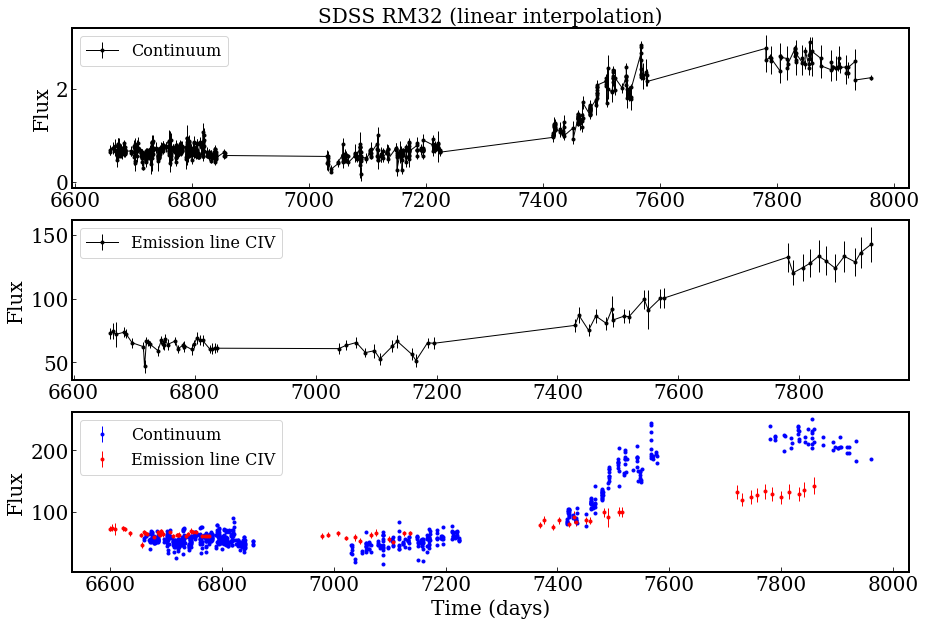

In [52]:
plt.figure(figsize=(15,10))
plt.subplot(311)
plt.errorbar(c.t1,c.y1,yerr=c.e1,fmt='.-',color='k',lw=1,label='Continuum')
plt.ylabel('Flux')
plt.legend(fontsize=16)
plt.title('SDSS RM32 (linear interpolation)')
plt.subplot(312)
plt.errorbar(c.t2,c.y2,yerr=c.e2,fmt='.-',color='k',lw=1,label='Emission line CIV')
plt.ylabel('Flux')
plt.legend(fontsize=16)
plt.subplot(313)
plt.errorbar(c.t1,c.y1*c.y2.mean()/c.y1.mean(),yerr=c.e1,fmt='.',color='b',lw=1,label='Continuum')
plt.errorbar(c.t2-c.lag_cen_MC[1],c.y2,yerr=c.e2,fmt='.',color='r',lw=1,label='Emission line CIV')
plt.xlabel('Time (days)')
plt.ylabel('Flux')
plt.legend(fontsize=16)

#### 3) Plot the CCF result.  
We run two-way calcualtion: y1 with interpolated y2 or interpolated y1 with y2. We also calculate the data-based CCF. If the peak hits the boundaries, we call it failed CCF, which is removed in STEP 4.

Text(0.01,0.8,'$\\rm \\tau_{cen}=$51.81')

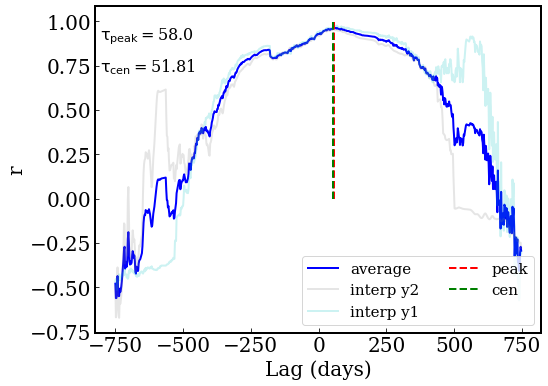

In [53]:
plt.figure(figsize=(8,6))
ax=plt.subplot(111)
plt.plot(c.lag,c.r,'b',label='average')
plt.xlabel('Lag (days)')
plt.ylabel('r')


plt.plot(c.lag_2,c.r_2,'grey',alpha=0.2,label='interp y2')
plt.plot(c.lag_1,c.r_1,'c',alpha=0.2,label='interp y1')


lag_peak, lag_cen, r_peak, r_cen = c.Lag_center(c.lag,c.r)

plt.plot([lag_peak,lag_peak],[0,1],'r--',label='peak')

plt.plot([lag_cen,lag_cen],[0,1],'g--',label='cen')
plt.legend(loc=4,fontsize=15,ncol=2)

plt.text(0.01,0.9,r'$\rm \tau_{peak}=$'+str(np.round(lag_peak,2)),transform = ax.transAxes,fontsize=16)
plt.text(0.01,0.8,r'$\rm \tau_{cen}=$'+str(np.round(lag_cen,2)),transform = ax.transAxes,fontsize=16)

#### 4) Run flux randomization with Monte Carlo method and plot the lag distributions.
We perturb the flux with a zero-mean random Gaussian noise whose $\sigma$ is the original error at each time. Also failed CCFs are excluded if have. 

(1000,) 0


Text(0.01,0.9,'$\\rm \\tau_{cen}=56.53^{+59.03}_{-28.22}$')

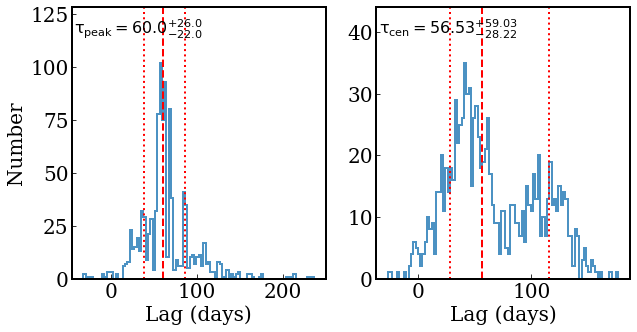

In [54]:
plt.figure(figsize=(10,5))
ax=plt.subplot(121)
plt.hist(c.lag_peak_MC,bins=100,histtype='step',lw=2,alpha=0.8)
ymin,ymax=plt.ylim()
ymax=ymax*1.2
plt.plot([c.peak_pack_MC[1]-c.peak_pack_MC[0],c.peak_pack_MC[1]-c.peak_pack_MC[0]],[ymin,ymax],'r:')
plt.plot([c.peak_pack_MC[1],c.peak_pack_MC[1]],[ymin,ymax],'r--')
plt.plot([c.peak_pack_MC[1]+c.peak_pack_MC[2],c.peak_pack_MC[1]+c.peak_pack_MC[2]],[ymin,ymax],'r:')
plt.ylim(ymin,ymax)
plt.ylabel('Number')
plt.xlabel('Lag (days)')
plt.text(0.01,0.9,r'$\rm \tau_{peak}='+str(c.peak_pack_MC[1])+'^{+'+str(c.peak_pack_MC[2])+'}'
         +'_{-'+str(c.peak_pack_MC[0])+'}$',transform = ax.transAxes,fontsize=16)

ax=plt.subplot(122)
plt.hist(c.lag_cen_MC,bins=100,histtype='step',lw=2,alpha=0.8)
ymin,ymax=plt.ylim()
ymax=ymax*1.2
plt.plot([c.cen_pack_MC[1]-c.cen_pack_MC[0],c.cen_pack_MC[1]-c.cen_pack_MC[0]],[ymin,ymax],'r:')
plt.plot([c.cen_pack_MC[1],c.cen_pack_MC[1]],[ymin,ymax],'r--')
plt.plot([c.cen_pack_MC[1]+c.cen_pack_MC[2],c.cen_pack_MC[1]+c.cen_pack_MC[2]],[ymin,ymax],'r:')
plt.ylim(ymin,ymax)
print c.lag_peak_MC.shape,c.failed_CCF_MC
plt.xlabel('Lag (days)')
plt.text(0.01,0.9,r'$\rm \tau_{cen}='+str(c.cen_pack_MC[1])+'^{+'+str(c.cen_pack_MC[2])+'}'
         +'_{-'+str(c.cen_pack_MC[0])+'}$',transform = ax.transAxes,fontsize=16)

#### 5) Plot the CCF simulation results.
We also run two-way simulations: measure CCF with real y1 and simulated y2, and real y2 and simulated y1. We define the null hypothesis as the fraction of the simulated CCF peaks exceeding the real-data-based CCF peak. Also, we plot the 1-3 $\sigma$ levels of our CCF simulations. Here p_positive = 0.021 means in 1000 trials, there are 21 trials have the r_max higher than data-based r_max.   

Text(0.02,0.1,'$\\rm p_{positive}=$0.03119')

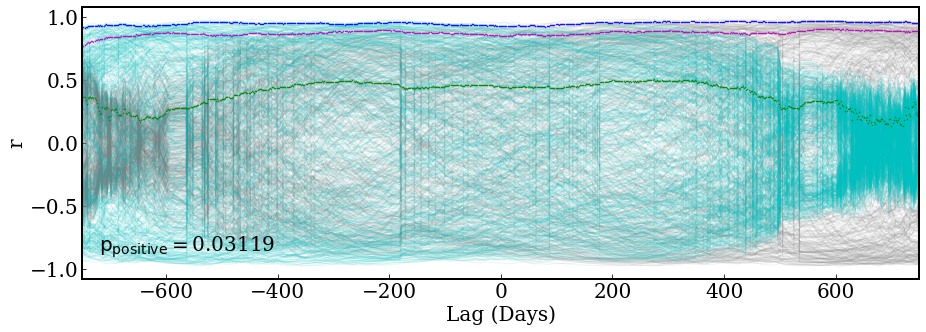

In [55]:
plt.figure(figsize=(15,5))
ax=plt.subplot(111)
for i in range(c.r_sim.shape[0]):
    if i <c.r_sim.shape[0]/2.:
        plt.plot(c.lag_sim[i,:],c.r_sim[i,:],'gray',lw=1,alpha=0.1)
    else:
        plt.plot(c.lag_sim[i,:],c.r_sim[i,:],'c',lw=1,alpha=0.1)

for i in range(c.r_sim.shape[1]):
    plt.plot(c.lag_sim[0,i],np.percentile(c.r_sim[:,i], 68.3),'g.',ms=1)
    plt.plot(c.lag_sim[0,i],np.percentile(c.r_sim[:,i], 95.5),'m.',ms=1)
    plt.plot(c.lag_sim[0,i],np.percentile(c.r_sim[:,i], 99.7),'b.',ms=1)

plt.plot([],[],'g',label=r'$\rm 1\sigma$')
plt.plot([],[],'m',label=r'$\rm 2\sigma$')
plt.plot([],[],'b',label=r'$\rm 3\sigma$')
plt.xlim(c.tau_min,c.tau_max)
plt.xlabel('Lag (Days)')
plt.ylabel('r')

plt.text(0.02,0.1,r'$\rm p_{positive}=$'+str(c.p_positive),transform = ax.transAxes,fontsize=20)

#### 6) Check the difference between two-way simulations. 
It shows no much difference between two ways for this objects.

Text(0.5,1,'Simulated y2')

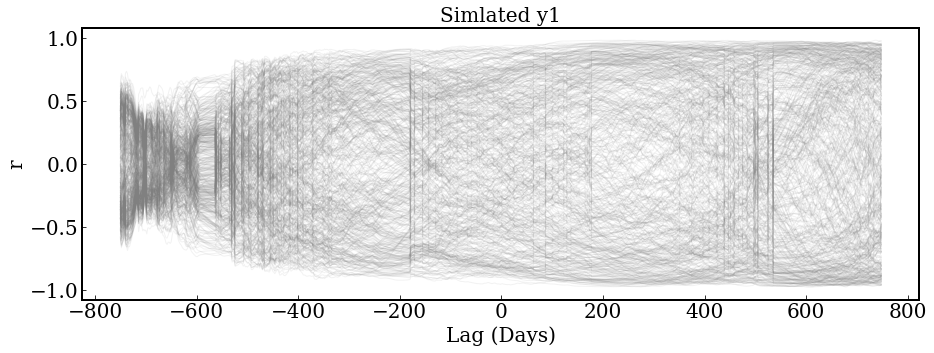

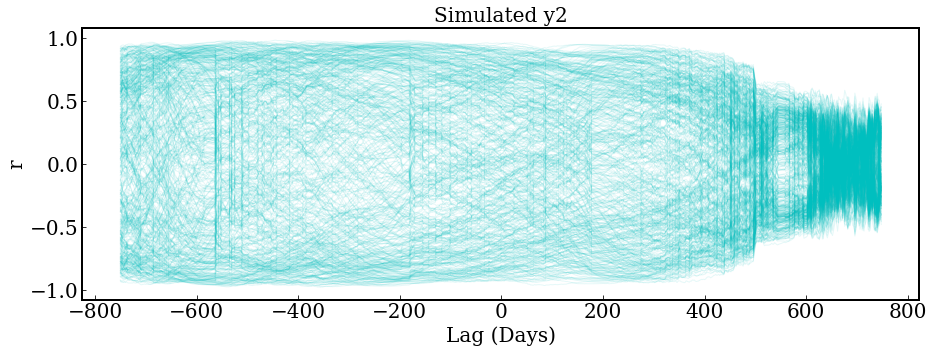

In [56]:
plt.figure(figsize=(15,5))
for i in range(c.r_sim.shape[0]):
    if i <c.r_sim.shape[0]/2.:
        plt.plot(c.lag_sim[i,:],c.r_sim[i,:],'gray',lw=1,alpha=0.1)
plt.xlabel('Lag (Days)')
plt.ylabel('r')
plt.title('Simlated y1')

plt.figure(figsize=(15,5))
for i in range(c.r_sim.shape[0]):
    if i >c.r_sim.shape[0]/2.:
        plt.plot(c.lag_sim[i,:],c.r_sim[i,:],'c',lw=1,alpha=0.1)
plt.xlabel('Lag (Days)')
plt.ylabel('r')
plt.title('Simulated y2')

#### 7) Randomly plot 10 simulated CCFs exceeding real-data CCF. 

Text(0,0.5,'r')

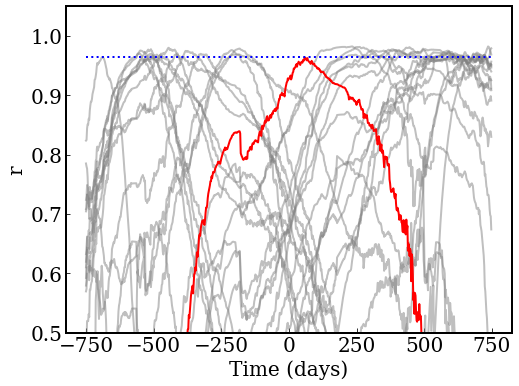

In [57]:
plt.figure(figsize=(8,6))
for i in range(c.r_sim.shape[0]):
    if c.r_sim[i,:].max()>c.r.max():
        plt.plot(c.lag_sim[i,:],c.r_sim[i,:],'grey',alpha=0.5)
plt.plot(c.lag,c.r,'r')
plt.plot([-750,750],[c.r.max(),c.r.max()],'b:')
plt.ylim(0.5,1.05)
plt.xlabel('Time (days)')
plt.ylabel('r')



####  8) Plot the distribution of lag and r_max.
Simulated light curves produced many failed CCF results, which hit the boundaries. We did not remove them in significance evaluation. 

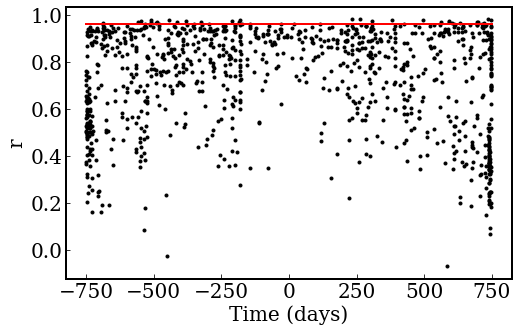

In [58]:
plt.figure(figsize=(8,5))
for i in range(c.r_sim.shape[0]):
    plt.plot(c.lag[np.argmax(c.r_sim[i,:])],c.r_sim[i,:].max(),'k.')
plt.xlabel('Time (days)')
plt.ylabel('r')

plt.plot([c.tau_min,c.tau_max],[c.r.max(),c.r.max()],'r-')



#### 9) Plot the distributions of r_peak and r_cen. 

Text(0.5,0,'tau')

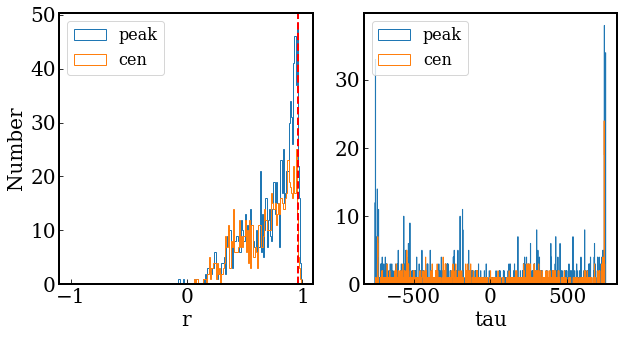

In [59]:
plt.figure(figsize=(10,5))
plt.subplot(121)
a=plt.hist(c.r_sim_peak,np.arange(-1.,1.,0.01),histtype='step',label='peak')
a=plt.hist(c.r_sim_cen,np.arange(-1.,1.,0.01),histtype='step',label='cen')
plt.legend(fontsize=16,loc=2)

ymin,ymax=plt.ylim()
plt.plot([c.r.max(),c.r.max()],[ymin,ymax],'r--')
plt.ylim(ymin,ymax)
plt.xlabel('r')
plt.ylabel('Number')

plt.subplot(122)

a=plt.hist(c.lag_sim_peak,np.arange(c.tau_min,c.tau_max,1),histtype='step',label='peak')
a=plt.hist(c.lag_sim_cen,np.arange(c.tau_min,c.tau_max,1),histtype='step',label='cen')
plt.legend(fontsize=16,loc=2)

ymin,ymax=plt.ylim()
plt.ylim(ymin,ymax)
plt.xlabel('tau')

#### 10) Plot 10 randomly selected simulated light curves. 

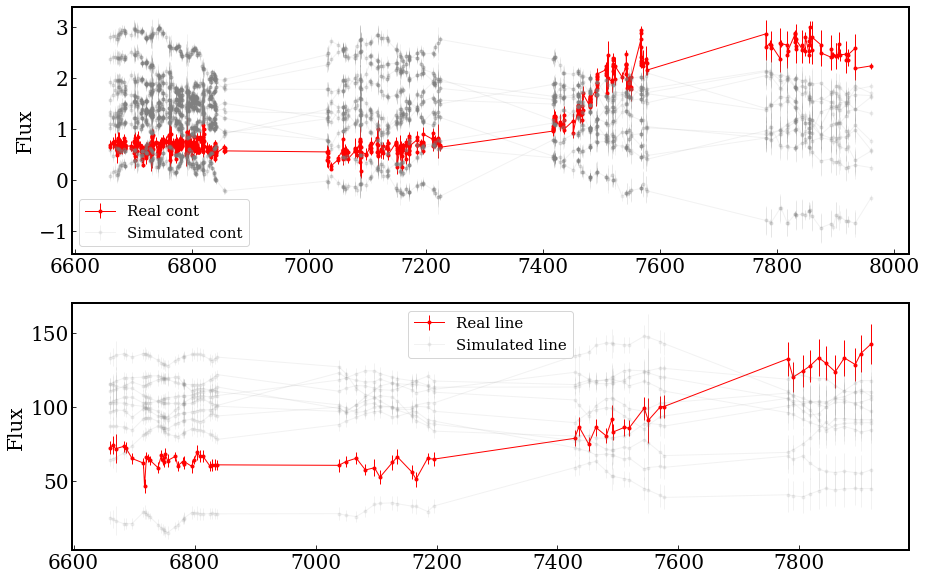

In [60]:
plt.figure(figsize=(15,10))
plt.subplot(211)
plt.errorbar(c.t1,c.y1,yerr=c.e1,fmt='.-',color='r',lw=1,label='Real cont')

for i in enumerate(np.random.randint(0,c.ysim_t1_cadence.shape[0],10)):
    plt.errorbar(c.t1,c.ysim_t1_cadence[i[1]],yerr=c.e1,fmt='.-',color='grey',lw=1,alpha=0.1)
plt.errorbar([],[],yerr=[],fmt='.-',color='grey',lw=1,alpha=0.1,label='Simulated cont')
plt.ylabel('Flux')
plt.legend(fontsize=15)


plt.subplot(212)
plt.errorbar(c.t2,c.y2,yerr=c.e2,fmt='.-',color='r',lw=1,label='Real line')
for i in enumerate(np.random.randint(0,c.ysim_t2_cadence.shape[0],10)):
    plt.errorbar(c.t2,c.ysim_t2_cadence[i[1]],yerr=c.e2,fmt='.-',color='grey',lw=1,alpha=0.1)
plt.errorbar([],[],yerr=[],fmt='.-',color='grey',lw=1,alpha=0.1,label='Simulated line')
plt.ylabel('Flux')
plt.legend(fontsize=15)


#### 11) Select the highest r produced from the simulated CCF result and check the appearance of the simulated light curves. 
We rerun the CCF to confirm the highest r. 

234.0 0.9826383649796032
0.9818513567750394


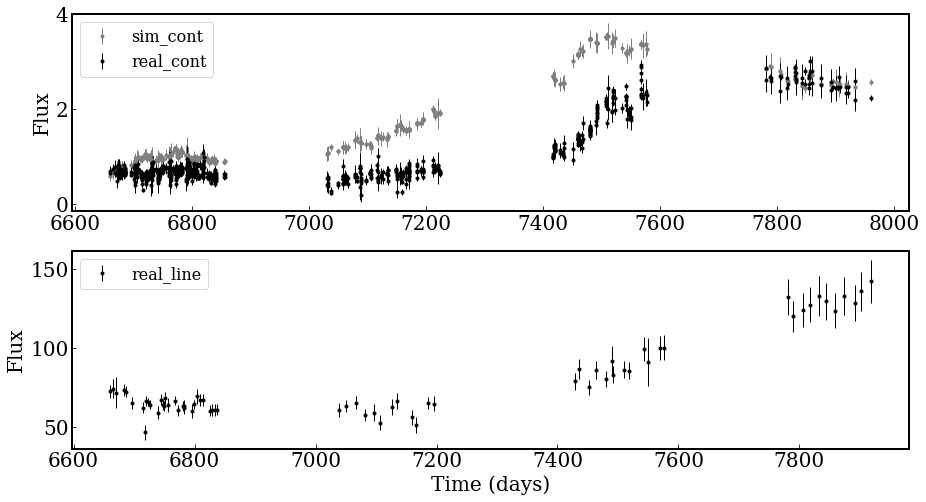

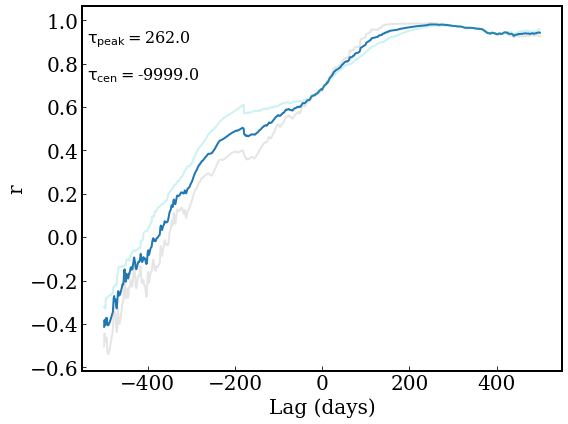

In [61]:
ind=np.where( (c.lag_sim_peak<c.tau_max) & (c.lag_sim_peak>0) & (c.r_sim_peak>c.r.max()))
idx= np.argmax(np.array(c.r_sim_peak)[ind])
ind_highest= np.array(ind).flatten()[idx]

print c.lag_sim_peak[ind][idx],c.r_sim_peak[ind][idx]
#print ind_highest

plt.figure(figsize=(15,8))
if ind_highest<c.sim_ntrials/2:
    #sim cont
    plt.subplot(211)
    plt.errorbar(c.t1,c.ysim_t1_cadence[ind_highest,:],yerr=c.e1,fmt='.',color='grey',lw=1,label='sim_cont')
    plt.errorbar(c.t1,c.y1,yerr=c.e1,fmt='.',color='k',lw=1,label='real_cont')
    plt.legend(fontsize=16)
    plt.ylabel('Flux')
    plt.subplot(212)
    plt.errorbar(c.t2,c.y2,yerr=c.e2,fmt='.',color='k',lw=1,label='real_line')
    plt.legend(fontsize=16)
    plt.ylabel('Flux')
    plt.xlabel('Time (days)')
    
    c1=CCF()
    c1.ICCF(c.t1,c.ysim_t1_cadence[ind_highest,:],c.e1,c.t2,c.y2,c.e2,tau_min=-500,tau_max=500,step=1,detrend=0,
         interp='linear',mcmc_nsamples=5000,auto_pq=False,p1=1,q1=0,p2=1,q2=0,carma_model='random',sig_cut=0.8,
         imode=0,MC_ntrials=0,sim_ntrials=0,weight=False,MP=True,plotLC=False,plotCCF=True,save=False)
    print  c1.r.max()
else:
    #sim line
    plt.subplot(211)
    plt.errorbar(c.t1,c.y1,yerr=c.e1,fmt='.',color='k',lw=1,label='real_cont')
    plt.ylabel('Flux')
    plt.legend(fontsize=16)
    plt.subplot(212)
    plt.errorbar(c.t2,c.y2,yerr=c.e2,fmt='.',color='k',lw=1,label='real_line')
    plt.errorbar(c.t2,c.ysim_t2_cadence[ind_highest-c.sim_ntrials/2,:],yerr=c.e2,fmt='.',color='grey',lw=1,label='sim_line')
    plt.ylabel('Flux')
    plt.xlabel('Time (days)')
    plt.legend(fontsize=16)
    
    c1=CCF()
    c1.ICCF(c.t1,c.y1,c.e1,c.t2,c.ysim_t2_cadence[ind_highest-c.sim_ntrials/2,:],c.e2,tau_min=-500,tau_max=500,step=1,detrend=0,
             interp='linear',mcmc_nsamples=5000,auto_pq=False,p1=1,q1=0,p2=1,q2=0,carma_model='random',sig_cut=0.8,
             imode=0,MC_ntrials=0,sim_ntrials=0,weight=False,MP=True,plotLC=False,plotCCF=True,save=False)
    print  c1.r.max()





#### 12) Measure the time lag with CARMA(1,0) model (a.k.a. DRW).
There are two choices for carma_model = "mean" or "random". "Mean" is the average DRW model for all samplers (similar to linear interpolation), while "random" is selecting a random realization, which is closer to reality. 


Fitting finished in : 369.22s


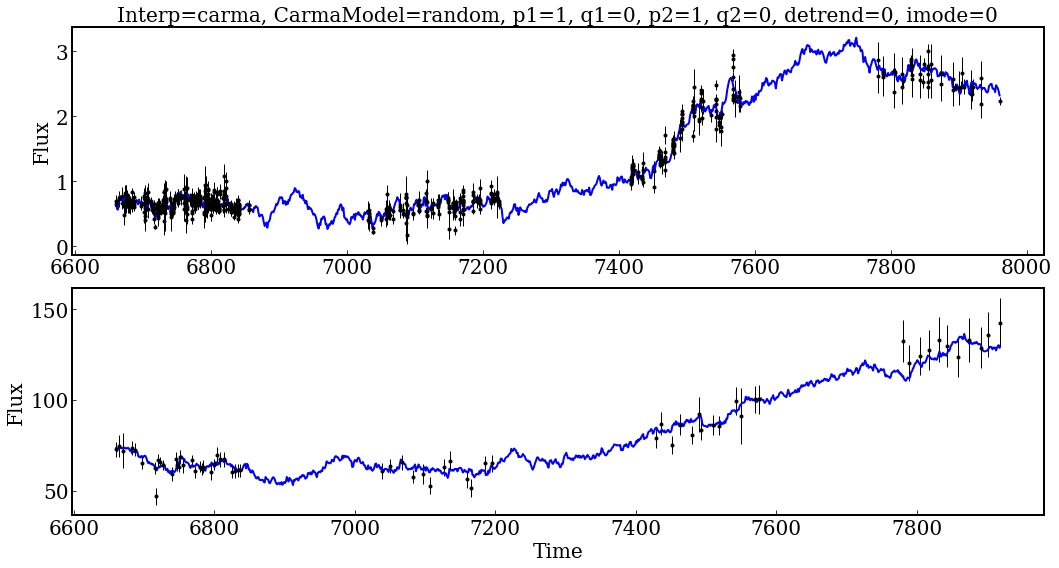

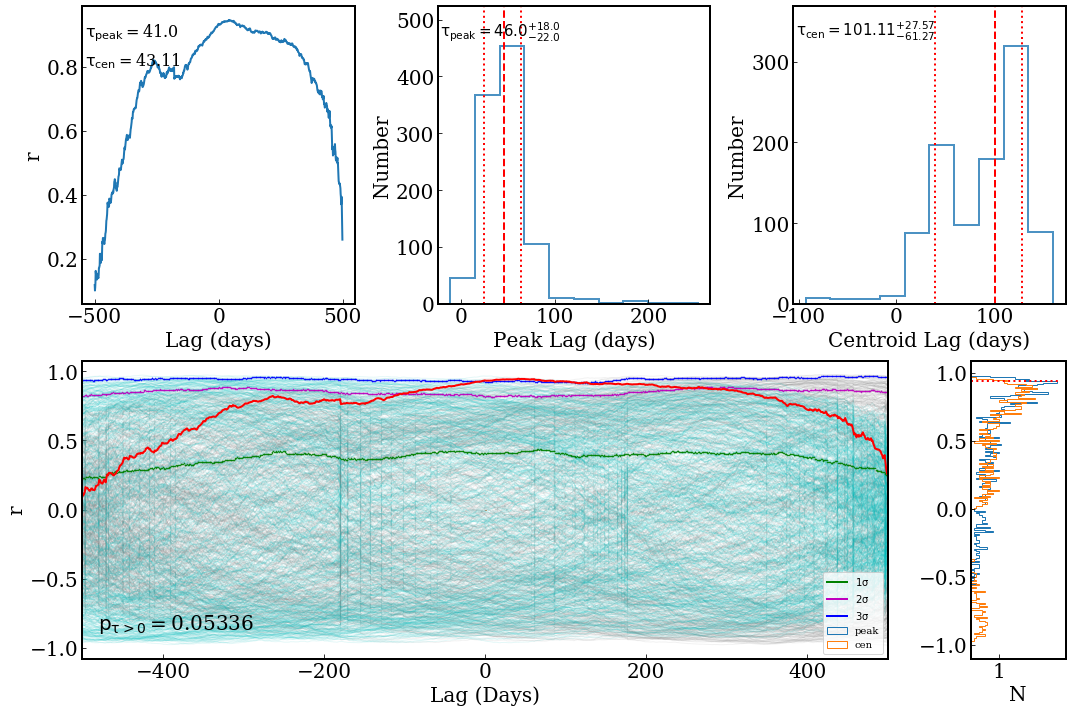

In [24]:
start = timeit.default_timer()
c=CCF()
c.ICCF(cont,conf,cone,linet,linef,linee,tau_min=-500,tau_max=500,step=1,detrend=0,
         interp='carma',mcmc_nsamples=5000,auto_pq=False,p1=1,q1=0,p2=1,q2=0,carma_model='random',sig_cut=0.8,
         imode=0,MC_ntrials=1000,sim_ntrials=1000,weight=False,MP=True,name='SDSSRM32_carma',plotLC=True,plotCCF=True,path='/Users/legolason/Desktop/')
end = timeit.default_timer()
print 'Fitting finished in : '+str(np.round(end-start,2))+'s'


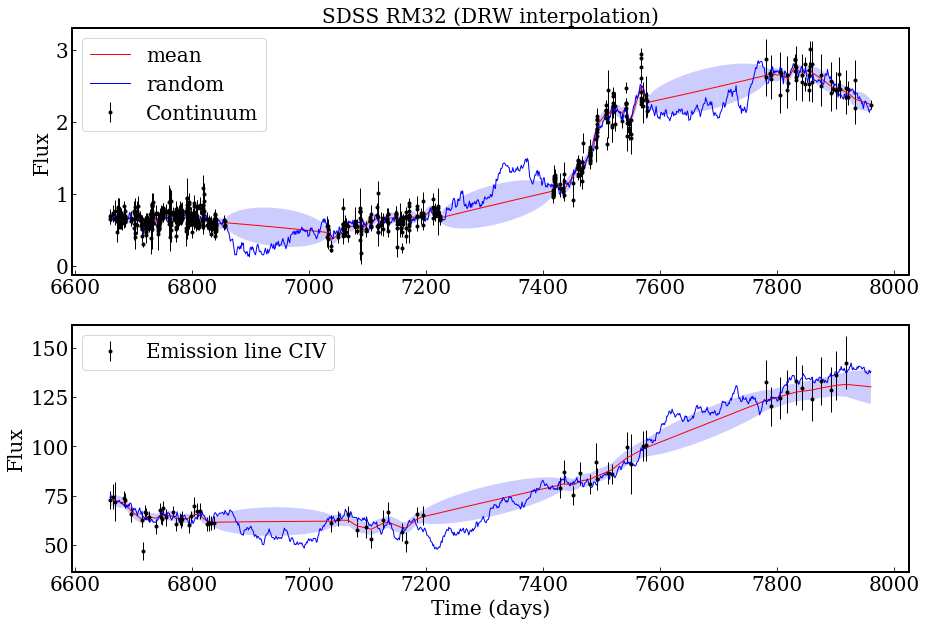

In [25]:
plt.figure(figsize=(15,10))
plt.subplot(211)
plt.errorbar(c.t1,c.y1,yerr=c.e1,fmt='.',color='k',lw=1,label='Continuum')
plt.ylabel('Flux')
plt.legend(fontsize=20)
plt.title('SDSS RM32 (DRW interpolation)')

time=np.linspace(cont.min(),cont.max(),1000)
# if carma_model = 'mean'
model_mean, model_var = c.sample1.predict(time, bestfit='map')
plt.plot(time,model_mean,'-r',lw=1,label='mean')
low = model_mean - np.sqrt(model_var)
high = model_mean + np.sqrt(model_var)
plt.fill_between(time, low,high, facecolor='blue', alpha=0.2)
# if carma_model = 'random'
ysim=c.sample1.simulate(time,bestfit='map')
plt.plot(time, ysim,'b',lw=1,label='random')
plt.legend(fontsize=20)

plt.subplot(212)
plt.errorbar(c.t2,c.y2,yerr=c.e2,fmt='.',color='k',lw=1,label='Emission line CIV')
plt.ylabel('Flux')
plt.xlabel('Time (days)')
plt.legend(fontsize=20)

model_mean, model_var = c.sample2.predict(time, bestfit='map')
plt.plot(time,model_mean,'-r',lw=1)
low = model_mean - np.sqrt(model_var)
high = model_mean + np.sqrt(model_var)

plt.fill_between(time, low,high, facecolor='blue', alpha=0.2)
ysim=c.sample2.simulate(time,bestfit='map')
plt.plot(time, ysim,'b',lw=1)